<img src="logoucm.png" style="height: 100px">

<h1><center>Calidad del aire en la Comunidad de Madrid</center></h1>

# Resumen

El Índice de Calidad del Aire (ICA) es un valor adimensional que se calcula a partir de los datos recopilados en las estaciones de monitoreo, teniendo en cuenta los límites establecidos por la legislación y los efectos nocivos para la salud de varios contaminantes.

El objetivo de este trabajo de fin de grado es desarrollar índices de calidad del aire pronosticados para cada una de las cinco zonas del municipio de Madrid. Además, se presentarán diferentes métodos para realizar una predicción diaria de la calidad del aire en la Comunidad de Madrid, utilizando la información disponible en el siguiente <a href="https://airedemadrid.madrid.es/portales/calidadaire/es/Servicios-y-recomendaciones/Prediccion-diaria/?vgnextfmt=default&vgnextchannel=e6ae471c5c503710VgnVCM1000008a4a900aRCRD">enlace</a>. 

# Introducción

Los datos utilizados en este trabajo fueron recopilados diariamente desde 2010 hasta 2021 por la Comunidad de Madrid. Estos datos se refieren a la concentración de diversos contaminantes medidos en 24 estaciones distribuidas en todo el territorio de la comunidad. La Comunidad de Madrid publica estos datos diariamente en su página web, en el Portal de Calidad del Aire, junto con un Índice de Calidad del Aire. El objetivo de este índice es proporcionar una evaluación de los efectos de la contaminación atmosférica en la salud.

Para obtener más información sobre las variables recopiladas, se puede consultar el Interprete fichero en el siguiente enlace: <a href="https://airedemadrid.madrid.es/portal/site/calidadaire">Interprete fichero</a>.

A continuación, se presenta una breve descripción de los datos recopilados:

| Atributo | Descripción |
| :- |:- |
|**PROVINCIA**| Identificador de la provincia (en este caso siempre '28'-Madrid)|
|**MUNICIPIO**| Identificador del municipio (en este caso siempre '79'-Mardrid|
|**ESTACION**| Identificador de la estación de recogida de los contaminantes|
|**MAGNITUD**| Identificador del contaminante|
|**PUNTO MUESTREO**| Identificador del punto de muestro|
|**ANO**| Año de recogida del dato|
|**MES**| Mes de recogida el dato|
|**D01**| D0_X_ indica el día del mes|
|**V01**| V0_X_ indica si el dato está verificado o no (Sí: "V", No: "N")|

# 0. Librerías

In [1]:
# Librerias 
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt  

from itertools import product

%matplotlib inline

C:\Users\sofia\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
import warnings
warnings.filterwarnings('ignore')

# 1. Análisis exploratorio de los datos

## 1.1 Limpieza de la base de datos

En primer lugar, procedemos a abrir el fichero que contiene los datos y analizamos su dimensión y estructura.

In [3]:
# Importacion de datos
df = pd.read_csv("./Datos/datos_total.csv", delimiter = ",")
df_original = df.copy()

df.head(5)

,Unnamed: 0,PROVINCIA,MUNICIPIO,ESTACION,MAGNITUD,PUNTO_MUESTREO,ANO,MES,D01,V01,...,D27,V27,D28,V28,D29,V29,D30,V30,D31,V31
0,0,28,79,4,1,28079004_1_38,2010,1,12.0,V,...,16.0,V,21.0,V,22.0,V,17.0,V,15.0,V
1,1,28,79,4,1,28079004_1_38,2010,2,18.0,V,...,15.0,V,13.0,V,0.0,N,0.0,N,0.0,N
2,2,28,79,4,1,28079004_1_38,2010,3,13.0,V,...,14.0,V,16.0,V,15.0,V,13.0,V,14.0,V
3,3,28,79,4,1,28079004_1_38,2010,4,14.0,V,...,9.0,V,9.0,V,9.0,V,9.0,V,0.0,N
4,4,28,79,4,1,28079004_1_38,2010,5,8.0,V,...,9.0,V,9.0,V,9.0,V,9.0,V,9.0,V


In [4]:
# Eliminacion de variables
df = df.drop(columns=['Unnamed: 0', 'PROVINCIA', 'MUNICIPIO'], axis = 1)

# Dimension de los datos
df.shape

(21633, 67)

Disponemos de un total de 21.633 registros que contienen información sobre 70 variables. Sin embargo, hemos eliminado las variables **_PROVINCIA_** y **_MUNICIPIO_** debido a su redundancia, ya que los datos se refieren exclusivamente a la Comunidad de Madrid. Además, hemos eliminado la variable **_Unnamed:0_**. Por lo tanto, la base de datos ahora se compone de las 67 variables restantes para cada uno de los 21.633 registros.

In [5]:
# Tipo de las variables y valores nulos
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21633 entries, 0 to 21632
Data columns (total 67 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ESTACION        21633 non-null  int64  
 1   MAGNITUD        21633 non-null  int64  
 2   PUNTO_MUESTREO  21633 non-null  object 
 3   ANO             21633 non-null  int64  
 4   MES             21633 non-null  int64  
 5   D01             21633 non-null  float64
 6   V01             21633 non-null  object 
 7   D02             21633 non-null  float64
 8   V02             21633 non-null  object 
 9   D03             21633 non-null  float64
 10  V03             21633 non-null  object 
 11  D04             21633 non-null  float64
 12  V04             21633 non-null  object 
 13  D05             21633 non-null  float64
 14  V05             21633 non-null  object 
 15  D06             21633 non-null  float64
 16  V06             21633 non-null  object 
 17  D07             21633 non-null 

A primera vista, la base de datos no muestra ningún valor faltante. Sin embargo, es importante tener en cuenta que existen datos no verificados. Esto significa que, aunque no haya valores explícitamente marcados como faltantes, algunos datos pueden no haber sido validados o requerir una verificación adicional para asegurar su precisión. En este contexto, sólo son válidos aquellos datos que estén acompañados por un código de verificación "V". 

Para abordar este problema, se reducirá la dimensión de la base de datos, conservando únicamente los compuestos presentes en la creación del índice de calidad del aire. Esto permitirá enfocar el análisis en las variables más relevantes para evaluar la calidad del aire. Esto es:

*Los compuestos que se emplean para calcular el índice de calidad son las partículas en suspensión (PM10 y PM2,5), dióxido de azufre, dióxido de nitrógeno y ozono. Para cada uno de estos contaminantes se establece un índice parcial, de forma que el peor valor de los cinco definirá el índice global y, por lo tanto, la calidad del aire en el municipio de Madrid.*

| Contaminantes | id| Muy bueno | Bueno | Regular | Malo | Muy malo |
| :- |:- |:-|:-|:-|:-| :-|
|Partículas PM2,5| 9| 0-15|16-30|31-55|56-110|>110|
|Partículas PM10| 10| 0-25|26-50|51-90|91-180|>180|
|NO2| 8| 0-50|51-100|101-200|201-400|>400|
|O3| 14|0-60|61-120|121-180|181-240|>240|
|SO2| 1|0-50|51-100|101-350|351-500|>500|
[Indices parciales](#indices-parciales)

Fuente: [Aire de Madrid](https://airedemadrid.madrid.es/portales/calidadaire/es/Bases-de-datos-y-publicaciones/Bases-de-datos-de-calidad-del-aire/Indices-y-zonas/Indice-de-Calidad-del-Aire/?vgnextfmt=default&vgnextoid=303d635a41187710VgnVCM1000001d4a900aRCRD&vgnextchannel=480285a1259d7710VgnVCM2000001f4a900aRCRD)

En consecuencia, se procede a la creación de una nueva base de datos con una estructura más apropiada para el análisis.

In [6]:
# Dataframe con los contaminantes de interes
df_contaminantes = df[(df['MAGNITUD'].isin([9, 10, 8, 14, 1]))]

# Listado de dias y correspondientes codigos de verificacion
dias = ['D01','D02','D03','D04','D05','D06','D07','D08','D09','D10',
       'D11','D12','D13','D14','D15','D16','D17','D18','D19','D20',
       'D21','D22','D23','D24','D25','D26','D27','D28','D29','D30','D31']

verf = ['V01','V02','V03','V04','V05','V06','V07','V08','V09','V10',
       'V11','V12','V13','V14','V15','V16','V17','V18','V19','V20',
       'V21','V22','V23','V24','V25','V26','V27','V28','V29','V30','V31']

# Formato long del dataframe
# Dias
df_dias = df_contaminantes.melt(id_vars=['ESTACION', 'MAGNITUD', 'PUNTO_MUESTREO', 'ANO', 'MES'],
                                value_vars = dias,
                                var_name = 'DIA',
                                value_name = 'VALOR')
# Verificaciones
df_verf= df_contaminantes.melt(id_vars=['ESTACION', 'MAGNITUD', 'PUNTO_MUESTREO', 'ANO', 'MES'],
                               value_vars = verf,
                               var_name = 'VER',
                               value_name = 'VV')

# Asociar los valores de verificacion
df_dias['VV'] = df_verf['VV']
df = df_dias

# Visualizacion
df.head(5)

,ESTACION,MAGNITUD,PUNTO_MUESTREO,ANO,MES,DIA,VALOR,VV
0,4,1,28079004_1_38,2010,1,D01,12.0,V
1,4,1,28079004_1_38,2010,2,D01,18.0,V
2,4,1,28079004_1_38,2010,3,D01,13.0,V
3,4,1,28079004_1_38,2010,4,D01,14.0,V
4,4,1,28079004_1_38,2010,5,D01,8.0,V


Con este dataframe, vamos a diferenciar entre los valores no verificados (aquellos que están seguidos de una código de verificación 'N') y los valores no medidos debido a la inexistencia de un día en particular (por ejemplo, el 30 de febrero).

Para comenzar, eliminamos del dataframe aquellos registros correspondientes a los días que no existen.

In [7]:
# Creacion de la columna 'date'
date_str = df['ANO'].astype(str) + '-' + df['MES'].astype(str) + '-' + df['DIA'].str.replace('D', '').astype(str)
df['date'] = pd.to_datetime(date_str, format='%Y-%m-%d', errors='coerce')

# Eliminacion de los registros con dias inexistentes
df = df.dropna(subset=['date'])

# Reordanacion de las columnas
df = df[['ESTACION', 'MAGNITUD', 'PUNTO_MUESTREO', 'ANO', 'MES', 'DIA', 'date', 'VALOR', 'VV']]

# Reordenacion de los registros por fecha
df = df.sort_values(['ESTACION','MAGNITUD','ANO','MES'])

En segundo lugar, vamos a asignar el valor $-1$ a los datos no verificados para poder llevar a cabo una imputación de dichos valores. De esta manera, en análisis posteriores, podremos diferenciar los datos no verificados de aquellos que no están registrados.

In [8]:
# Asignacion de valores missing
df.loc[df['VV'] != 'V', 'VALOR'] = -1
df = df.drop(['VV'], axis = 1)

Por último, estudiamos la presencia de valores nulos y datos no verificados y nos aseguramos de que no existan filas duplicadas.

In [9]:
# Comprobacion valores nulos y duplicados
print("Numero de valores nulos en las diferentes variables:") 
print(df.isnull().sum())
print("\nNumero de datos no verificados:", (df['VALOR'] == -1).sum())
print("\nNumero de registros duplicados:" ,df.duplicated().sum())

Numero de valores nulos en las diferentes variables:
ESTACION          0
MAGNITUD          0
PUNTO_MUESTREO    0
ANO               0
MES               0
DIA               0
date              0
VALOR             0
dtype: int64

Numero de datos no verificados: 3920

Numero de registros duplicados: 0


## 1.2 Imputación de missing

Una primera aproximación para tratar los datos missing podría ser utilizar la técnica de interpolación lineal. La interpolación lineal calcula un valor promedio entre dos puntos conocidos y este se utiliza para reemplazar el valor faltante. Es importante destacar que, al utilizar la interpolación lineal, estamos asumiendo una relación lineal entre los datos.

Otra opción es realizar la imputación de missing examinando los contaminantes en diferentes zonas geográficas de la Comunidad de Madrid. Según la división establecida, las zonas se definen de la siguiente manera:

* **Zona 1 (interior M30)**: 7 estaciones de tráfico (Escuelas Aguirre, Castellana, Plaza de Castilla, Ramón y Cajal, Cuatro Caminos, Plaza de España y Barrio del Pilar) + 3 estaciones de fondo (Plaza del Carmen, Méndez Álvaro y Retiro).
* **Zona 2 (Sureste)**: 1 estación de tráfico (Moratalaz) y 2 estaciones de fondo (Vallecas y Ensanche de Vallecas).
* **Zona 3 (Noreste)**: 5 estaciones de fondo (Arturo Soria, Sanchinarro, Urbanización Embajada, Barajas Pueblo y Tres Olivos) y 1 estación suburbana (Juan Carlos I).
* **Zona 4 (Noroeste)**: 2 estaciones suburbanas (El Pardo y Casa de Campo).
* **Zona 5 (Suroeste)**: 1 estación de tráfico (Plaza Elíptica) y 2 estaciones de fondo (Farolillo y Villaverde).

De esta forma, realizaremos la imputación de los valores que no han sido validados.

In [10]:
# Dataframe con todas las zonas
df_zonas = df.pivot_table(index=['MAGNITUD','ANO', 'MES', 'DIA', 'date'], columns='ESTACION', values='VALOR')
df_zonas = df_zonas.reset_index()
df_zonas.drop(['ANO','MES','DIA'],axis=1, inplace=True)
df_zonas = df_zonas.set_index('date')

# Renombrar columnas
cols = df_zonas.columns
nombres = {col: str(col) for col in cols}
df_zonas = df_zonas.rename(columns=nombres)

# Renombrar magnitudes
nombres_magnitudes = {1: 'SO2', 8: 'NO2', 9: 'PM2.5', 10: 'PM10', 14: 'O3'}
df_zonas['MAGNITUD'] = df_zonas['MAGNITUD'].map(nombres_magnitudes)

# Visualizacion
df_zonas.head(5)

ESTACION,MAGNITUD,4,8,11,16,17,18,24,27,35,...,48,49,50,54,55,56,57,58,59,60
date,,,,,,,,,,,,,,,,,,,,,
2010-01-01,SO2,12.0,9.0,NaN,NaN,7.0,5.0,7.0,NaN,10.0,...,NaN,NaN,NaN,NaN,NaN,NaN,6.0,NaN,NaN,NaN
2010-01-02,SO2,15.0,10.0,NaN,NaN,7.0,6.0,7.0,NaN,11.0,...,NaN,NaN,NaN,NaN,NaN,NaN,8.0,NaN,NaN,NaN
2010-01-03,SO2,17.0,11.0,NaN,NaN,8.0,10.0,8.0,NaN,14.0,...,NaN,NaN,NaN,NaN,NaN,NaN,8.0,NaN,NaN,NaN
2010-01-04,SO2,16.0,12.0,NaN,NaN,8.0,10.0,8.0,NaN,13.0,...,NaN,NaN,NaN,NaN,NaN,NaN,7.0,NaN,NaN,NaN
2010-01-05,SO2,16.0,12.0,NaN,NaN,8.0,10.0,8.0,NaN,13.0,...,NaN,NaN,NaN,NaN,NaN,NaN,7.0,NaN,NaN,NaN


In [11]:
# Indices de las estaciones en las diferentes zonas
zona1 = ['8','48','50','11','10','4','5','3','47','9'] # la 3,5,9 y 10 no estan --> buscar como incluirlas
zona2 = ['20','13','54'] # la 20 y 13 no estan
zona3 = ['16','57','55','27','86','59'] # la 86 no esta
zona4 = ['58','24']
zona5 = ['56','18','17']

# Dataframe por zonas
# Zona 1
zona1 = df_zonas[['8','48','50','11','4','47']]

# Zona 2
zona2 = df_zonas[['54']]

# Zona 3
zona3 = df_zonas[['16','57','55','27','59']]

# Zona 4
zona4 = df_zonas[['58', '24']]

# Zona 5
zona5 = df_zonas[['56','18','17']]

Para imputar los valores faltantes, procederemos de la siguiente manera:

1. Si exiten mediciones del contaminante en otras estaciones de la misma zona, es decir, si alguna de las columnas tiene un valor distinto de NaN, imputaremos la media de esos valores.
2. En caso contrario,  utilizaremos la técnica de interpolación lineal.

A continuación, creamos una función para llevar a cabo este proceso:

In [12]:
def imputar_missing(df):
    # Imputar missing cuando hay datos de otras estaciones
    for i in range(len(df)):
        fila = df.iloc[i,:]
        if (fila == -1).any():
            indices = np.where(df.iloc[i,:] == -1)[0]
            suma = fila.sum() + len(indices)
            if (suma) > 0:
                media = suma/(sum(fila>0))
                fila[indices] = media    
                
    # Imputar missing cuando no hay datos de otras estaciones
    for col in df:
        df[col] = df[col].replace(-1, np.nan)
        df[col] = df[col].interpolate()
    
    return df

Realizamos primero la imputación de los valores faltantes en la **Zona 1 (M30 interior)**.

In [13]:
# Numero de valores faltantes en las diferentes variables
print("Numero de valores no verificados en las diferentes estaciones de la Zona 1:", )
print(zona1.isin([-1]).sum())

Numero de valores no verificados en las diferentes estaciones de la Zona 1:
ESTACION
8     468
48    188
50    350
11     11
4     303
47    188
dtype: int64


In [14]:
# Imputacion de missing
zona1 = imputar_missing(zona1)

Verificamos que no haya valores no verficados después de la imputación.

In [15]:
# Numero de valores faltantes en las diferentes variables
print("Numero de valores no verificados en las diferentes estaciones de la Zona 1:", )
print(zona1.isin([-1]).sum())

Numero de valores no verificados en las diferentes estaciones de la Zona 1:
ESTACION
8     0
48    0
50    0
11    0
4     0
47    0
dtype: int64


Procedemos de manera análoga con el resto de zonas.

In [16]:
# Imputacion de missing
zona2 = imputar_missing(zona2)
zona3 = imputar_missing(zona3)
zona4 = imputar_missing(zona4)
zona5 = imputar_missing(zona5)

Comprobamos nuevamente que no existan valores nulos después de la imputación en ninguno de los dataframe de las diferentes zonas.

In [17]:
# Numero de valores faltantes en las diferentes variables 
print("Numero de valores no verificados en las diferentes estaciones de la Zona 2:", )
print(zona2.isin([-1]).sum())
# Numero de valores faltantes en las diferentes variables
print("\nNumero de valores no verificados en las diferentes estaciones de la Zona 3:", )
print(zona3.isin([-1]).sum())
# Numero de valores faltantes en las diferentes variables
print("\nNumero de valores no verificados en las diferentes estaciones de la Zona 4:", )
print(zona4.isin([-1]).sum())
# Numero de valores faltantes en las diferentes variables
print("\nNumero de valores no verificados en las diferentes estaciones de la Zona 5:", )
print(zona5.isin([-1]).sum())

Numero de valores no verificados en las diferentes estaciones de la Zona 2:
ESTACION
54    0
dtype: int64

Numero de valores no verificados en las diferentes estaciones de la Zona 3:
ESTACION
16    0
57    0
55    0
27    0
59    0
dtype: int64

Numero de valores no verificados en las diferentes estaciones de la Zona 4:
ESTACION
58    0
24    0
dtype: int64

Numero de valores no verificados en las diferentes estaciones de la Zona 5:
ESTACION
56    0
18    0
17    0
dtype: int64


Finalmente, creamos una base de datos que agrupa todas las zonas y bases de datos específicas para cada zona definida.

In [18]:
# Crear el dataframe con las zonas de estudio
df_estaciones = pd.concat([zona1, zona2, zona3, zona4, zona5], axis=1)
df_estaciones['MAGNITUD'] = df_zonas['MAGNITUD']

In [19]:
# Magnitudes para las zonas
zona1['MAGNITUD'] = df_estaciones['MAGNITUD']
zona2['MAGNITUD'] = df_estaciones['MAGNITUD']
zona3['MAGNITUD'] = df_estaciones['MAGNITUD']
zona4['MAGNITUD'] = df_estaciones['MAGNITUD']
zona4['MAGNITUD'] = df_estaciones['MAGNITUD']
zona5['MAGNITUD'] = df_estaciones['MAGNITUD']

## 1.3 Análisis descriptivo

Para continuar con el estudio, llevamos a cabo un análisis descriptivo de los datos. Para ello, creamos dos dataframes: uno que contiene la información de las magnitudes o contaminantes y otro que está agrupado por zonas geográficas.

**Por magnitudes**

En primer lugar, analizamos el dataframe relacionado con los contaminantes. 

In [20]:
# Dataframe con las series temporales de los contaminantes
df_magnitudes = df.pivot_table(index=['ESTACION', 'ANO', 'MES', 'DIA', 'date'], columns='MAGNITUD', values='VALOR')
df_magnitudes = df_magnitudes.reset_index()

# Renombrar columnas
df_magnitudes.columns = ['ESTACION','ANO','MES','DIA','date','SO2', 'NO2', 'PM2.5', 'PM10','O3']

# Visualizacion
df_magnitudes.head(5)

,ESTACION,ANO,MES,DIA,date,SO2,NO2,PM2.5,PM10,O3
0,4,2010,1,D01,2010-01-01,12.0,12.0,NaN,NaN,NaN
1,4,2010,1,D02,2010-01-02,15.0,40.0,NaN,NaN,NaN
2,4,2010,1,D03,2010-01-03,17.0,51.0,NaN,NaN,NaN
3,4,2010,1,D04,2010-01-04,16.0,53.0,NaN,NaN,NaN
4,4,2010,1,D05,2010-01-05,16.0,46.0,NaN,NaN,NaN


Como se puede observar, no todas las estaciones miden todos los contaminantes. Por tanto, para ajustar un modelo de series temporales, tomamos el promedio diario del contaminante utilizando todas las estaciones de medición.

In [21]:
# Calculo promedio diario
ts_magnitudes = df_magnitudes.groupby('date').mean()
ts_magnitudes.drop(columns=['ESTACION', 'MES'], inplace=True)

El siguiente gráfico muestra las tendencias medias por año de los diferentes contaminantes. Cada línea representa un contaminante específico. En el eje x se encuentran los años, mientras que en el eje y se muestran los valores promedio.

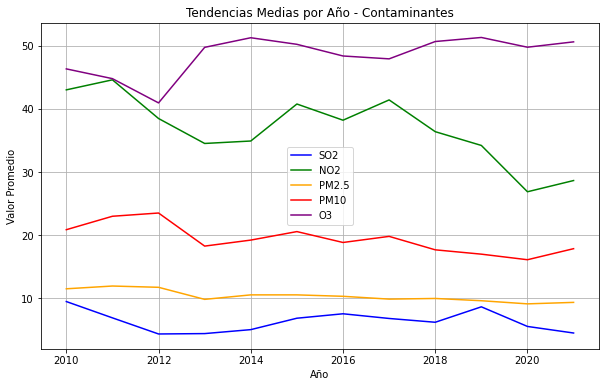

In [22]:
# Calcular las medias por año
contaminantes = ['SO2', 'NO2', 'PM2.5', 'PM10', 'O3']
media_anual = ts_magnitudes.groupby('ANO').mean()

# Grafico
plt.figure(figsize=(10, 6))

colors = ['blue', 'green', 'orange', 'red', 'purple']
for i, contaminante in enumerate(contaminantes):
    plt.plot(media_anual.index, media_anual[contaminante], color=colors[i], label=contaminante)

plt.title('Tendencias Medias por Año - Contaminantes')
plt.xlabel('Año')
plt.ylabel('Valor Promedio')
plt.legend() # Buscar mejor sitio
plt.grid(True)

plt.show()

Como se mostró previamente en la figura [Indices parciales](#indices-parciales), podemos crear un índice parcial por contaminante donde se utiliza la siguiente nomenclatura:
* 1: Muy Bueno
* 2: Bueno
* 3: Regular
* 4: Malo
* 5: Muy Malo

In [23]:
def indice_parcial(valores, magnitud):
    # Etiqueta de calidad del aire
    labels = [1,2,3,4,5]
    
    # Indice segun las diferentes magnitudes
    if magnitud == 'SO2':
        bins = [0,50,100,350,500,float("inf")]
        indice = pd.cut(valores, bins=bins, labels=labels)
        
    elif magnitud == 'NO2':
        bins = [0,50,100,200,400,float("inf")]
        indice = pd.cut(valores, bins=bins, labels=labels)
    
    elif magnitud == 'PM2.5':
        bins = [0,15,30,55,110,float("inf")]
        indice = pd.cut(valores, bins=bins, labels=labels)
    
    elif magnitud == 'PM10':
        bins = [0,25,50,90,180,float("inf")]
        indice = pd.cut(valores, bins=bins, labels=labels)
    
    elif magnitud == 'O3':
        bins = [0,60,120,180,240,float("inf")]
        indice = pd.cut(valores, bins=bins, labels=labels)
        
    else:
        print('El contaminante no es valido')
        
    return indice

Además, podemos crear un índice general  que se obtiene a partir de los índices parciales y se calcula tomando el valor más alto entre ellos. De esta manera, el índice general representa el nivel de restricción más alto entre todos los contaminantes considerados.

In [24]:
def indice_general(arr):
    indice = np.max(arr)
    return indice

Aplicamos estas funciones a la base de datos agrupada por contaminantes para generar los índices parciales correspondientes a cada contaminante, así como el índice general que engloba todas las mediciones.

In [25]:
# Indice para S02
ts_magnitudes['I1'] = indice_parcial(ts_magnitudes['SO2'], 'SO2')

# Indice para N02
ts_magnitudes['I2'] = indice_parcial(ts_magnitudes['NO2'], 'NO2')

# Indice para PM2.5
ts_magnitudes['I3'] = indice_parcial(ts_magnitudes['PM2.5'], 'PM2.5')

# Indice para PM10
ts_magnitudes['I4'] = indice_parcial(ts_magnitudes['PM10'], 'PM10')

# Indice para O3
ts_magnitudes['I5'] = indice_parcial(ts_magnitudes['O3'], 'O3')

# Indice general
ts_magnitudes['ICA'] = ts_magnitudes.loc[:,'I1':'I5'].apply(indice_general,axis=1)

# Visualizacion
ts_magnitudes.head(5)

,ANO,SO2,NO2,PM2.5,PM10,O3,I1,I2,I3,I4,I5,ICA
date,,,,,,,,,,,,
2010-01-01,2010.0,7.9,17.409091,7.00,8.0,51.785714,1,1,1,1,1,1
2010-01-02,2010.0,9.5,36.454545,10.00,12.0,23.500000,1,1,1,1,1,1
2010-01-03,2010.0,11.6,46.545455,12.25,13.1,10.642857,1,1,1,1,1,1
2010-01-04,2010.0,11.6,47.818182,9.00,7.6,11.357143,1,1,1,1,1,1
2010-01-05,2010.0,11.9,41.636364,8.00,9.5,19.714286,1,1,1,1,1,1


**Por zonas geográficas**

Durante el proceso de imputación de los valores no verificados, habíamos examinado los contaminantes por zonas. 

Por tanto, para calcular el índice parcial de cada contaminante en función de la zona, calculamos la media para cada fila del dataframe y utilizamos ese valor para generar el índice parcial correspondiente.

In [26]:
# Zona 1
zona1_media = zona1.groupby(['date','MAGNITUD']).mean()
zona1_media = zona1_media.mean(axis=1).reset_index()
zona1_media = zona1_media.rename(columns={0: 'valor'})
zona1_media = zona1_media.pivot_table(index=['date'], columns='MAGNITUD', values='valor')
zona1_media = zona1_media[contaminantes]

# Indice para S02
zona1_media['I1'] = indice_parcial(zona1_media['SO2'], 'SO2')

# Indice para N02
zona1_media['I2'] = indice_parcial(zona1_media['NO2'], 'NO2')

# Indice para PM2.5
zona1_media['I3'] = indice_parcial(zona1_media['PM2.5'], 'PM2.5')

# Indice para PM10
zona1_media['I4'] = indice_parcial(zona1_media['PM10'], 'PM10')

# Indice para O3
zona1_media['I5'] = indice_parcial(zona1_media['O3'], 'O3')

# Indice general
zona1_media['ICA'] = zona1_media.loc[:,'I1':'I5'].apply(indice_general,axis=1)

# Visualizacion
zona1_media.head(5)

MAGNITUD,SO2,NO2,PM2.5,PM10,O3,I1,I2,I3,I4,I5,ICA
date,,,,,,,,,,,
2010-01-01,10.5,22.75,28.247396,18.517681,28.166667,1,1,2,1,1,2
2010-01-02,12.5,45.25,28.828125,20.202029,23.833333,1,1,2,1,1,2
2010-01-03,14.0,57.50,29.075521,20.219709,22.000000,1,2,2,1,1,2
2010-01-04,14.0,57.25,27.822917,18.237390,21.833333,1,2,2,1,1,2
2010-01-05,14.0,50.50,27.403646,19.088405,23.333333,1,2,2,1,1,2


In [27]:
# Zona 2
zona2_media = zona2.groupby(['date','MAGNITUD']).mean()
zona2_media = zona2_media.mean(axis=1).reset_index()
zona2_media = zona2_media.rename(columns={0: 'valor'})
zona2_media = zona2_media.fillna(0)
zona2_media = zona2_media.pivot_table(index=['date'], columns='MAGNITUD', values='valor')
zona2_media = zona2_media[contaminantes]

# Indice para S02
zona2_media['I1'] = indice_parcial(zona2_media['SO2'], 'SO2')

# Indice para N02
zona2_media['I2'] = indice_parcial(zona2_media['NO2'], 'NO2')

# Indice para PM2.5
zona2_media['I3'] = indice_parcial(zona2_media['PM2.5'], 'PM2.5')

# Indice para PM10
zona2_media['I4'] = indice_parcial(zona2_media['PM10'], 'PM10')

# Indice para O3
zona2_media['I5'] = indice_parcial(zona2_media['O3'], 'O3')

# Indice general
zona2_media['ICA'] = zona2_media.loc[:,'I1':'I5'].apply(indice_general,axis=1)

# Visualizacion
zona2_media.head(5)

MAGNITUD,SO2,NO2,PM2.5,PM10,O3,I1,I2,I3,I4,I5,ICA
date,,,,,,,,,,,
2010-01-01,0.0,21.0,48.002623,59.501312,71.0,NaN,1,3,3,2,3
2010-01-02,0.0,47.0,48.005247,59.503935,36.0,NaN,1,3,3,1,3
2010-01-03,0.0,55.0,48.007870,59.506559,22.0,NaN,2,3,3,1,3
2010-01-04,0.0,56.0,48.010494,59.509182,24.0,NaN,2,3,3,1,3
2010-01-05,0.0,62.0,48.013117,59.511806,29.0,NaN,2,3,3,1,3


In [28]:
# Zona 3
zona3_media = zona3.groupby(['date','MAGNITUD']).mean()
zona3_media = zona3_media.mean(axis=1).reset_index()
zona3_media = zona3_media.rename(columns={0: 'valor'})
zona3_media = zona3_media.pivot_table(index=['date'], columns='MAGNITUD', values='valor')
zona3_media = zona3_media[contaminantes]

# Indice para S02
zona3_media['I1'] = indice_parcial(zona3_media['SO2'], 'SO2')

# Indice para N02
zona3_media['I2'] = indice_parcial(zona3_media['NO2'], 'NO2')

# Indice para PM2.5
zona3_media['I3'] = indice_parcial(zona3_media['PM2.5'], 'PM2.5')

# Indice para PM10
zona3_media['I4'] = indice_parcial(zona3_media['PM10'], 'PM10')

# Indice para O3
zona3_media['I5'] = indice_parcial(zona3_media['O3'], 'O3')

# Indice general
zona3_media['ICA'] = zona3_media.loc[:,'I1':'I5'].apply(indice_general,axis=1)

# Visualizacion
zona3_media.head(5)

MAGNITUD,SO2,NO2,PM2.5,PM10,O3,I1,I2,I3,I4,I5,ICA
date,,,,,,,,,,,
2010-01-01,6.0,22.75,38.9969,27.300217,33.6,1,1,3,2,1,3
2010-01-02,8.0,47.50,38.9938,31.700650,18.0,1,1,3,2,1,3
2010-01-03,8.0,54.75,38.9907,30.901084,13.0,1,2,3,2,1,3
2010-01-04,7.0,52.25,38.9876,26.901517,14.0,1,2,3,2,1,3
2010-01-05,7.0,49.00,38.9845,28.101950,16.8,1,1,3,2,1,3


In [29]:
# Zona 4
zona4_media = zona4.groupby(['date','MAGNITUD']).mean()
zona4_media = zona4_media.mean(axis=1).reset_index()
zona4_media = zona4_media.rename(columns={0: 'valor'})
zona4_media = zona4_media.pivot_table(index=['date'], columns='MAGNITUD', values='valor')
zona4_media = zona4_media[contaminantes]

# Indice para S02
zona4_media['I1'] = indice_parcial(zona4_media['SO2'], 'SO2')

# Indice para N02
zona4_media['I2'] = indice_parcial(zona4_media['NO2'], 'NO2')

# Indice para PM2.5
zona4_media['I3'] = indice_parcial(zona4_media['PM2.5'], 'PM2.5')

# Indice para PM10
zona4_media['I4'] = indice_parcial(zona4_media['PM10'], 'PM10')

# Indice para O3
zona4_media['I5'] = indice_parcial(zona4_media['O3'], 'O3')

# Indice general
zona4_media['ICA'] = zona4_media.loc[:,'I1':'I5'].apply(indice_general,axis=1)

# Visualizacion
zona4_media.head(5)

MAGNITUD,SO2,NO2,PM2.5,PM10,O3,I1,I2,I3,I4,I5,ICA
date,,,,,,,,,,,
2010-01-01,7.0,5.5,13.503194,28.501597,80.0,1,1,1,2,2,2
2010-01-02,7.0,26.5,15.006388,30.504791,35.5,1,1,2,2,1,2
2010-01-03,8.0,40.5,16.509581,33.007984,13.0,1,1,2,2,1,2
2010-01-04,8.0,53.0,15.512775,30.511178,16.5,1,2,2,2,1,2
2010-01-05,8.0,32.5,14.015969,29.014372,30.5,1,1,1,2,1,2


In [30]:
# Zona 5
zona5_media = zona5.groupby(['date','MAGNITUD']).mean()
zona5_media = zona5_media.mean(axis=1).reset_index()
zona5_media = zona5_media.rename(columns={0: 'valor'})
zona5_media = zona5_media.pivot_table(index=['date'], columns='MAGNITUD', values='valor')
zona5_media = zona5_media[contaminantes]

# Indice para S02
zona5_media['I1'] = indice_parcial(zona5_media['SO2'], 'SO2')

# Indice para N02
zona5_media['I2'] = indice_parcial(zona5_media['NO2'], 'NO2')

# Indice para PM2.5
zona5_media['I3'] = indice_parcial(zona5_media['PM2.5'], 'PM2.5')

# Indice para PM10
zona5_media['I4'] = indice_parcial(zona5_media['PM10'], 'PM10')

# Indice para O3
zona5_media['I5'] = indice_parcial(zona5_media['O3'], 'O3')

# Indice general
zona5_media['ICA'] = zona5_media.loc[:,'I1':'I5'].apply(indice_general,axis=1)

# Visualizacion
zona5_media.head(5)

MAGNITUD,SO2,NO2,PM2.5,PM10,O3,I1,I2,I3,I4,I5,ICA
date,,,,,,,,,,,
2010-01-01,6.0,18.5,52.327010,23.168675,53.0,1,1,3,1,1,3
2010-01-02,6.5,35.5,52.320686,24.837027,25.5,1,1,3,1,1,3
2010-01-03,9.0,45.0,52.314363,25.505379,12.5,1,1,3,2,1,3
2010-01-04,9.0,50.5,52.308039,24.173731,9.5,1,2,3,1,1,3
2010-01-05,9.0,45.5,52.301715,24.842083,18.5,1,1,3,1,1,3


Vamos a crear un mapa de la Comunidad de Madrid con las zonas agrupadas y representar el índice de calidad del aire general en cada zona mediante el uso de diferentes colores.

In [31]:
#!pip install folium

In [32]:
# Librerias
import folium
from folium.plugins import MarkerCluster
from folium.vector_layers import Polygon

In [33]:
# Crear mapa centrado en la Comunidad de Madrid
madrid_map = folium.Map(location=[40.4168, -3.7038], zoom_start=11)

In [34]:
# Definir las zonas 
# Coordenadas zona 1 - Interior 
zona1_coordinates = [[40.474580, -3.750343], [40.480848, -3.674468], 
                     [40.386772, -3.662109], [40.388341, -3.734893]]

# Coordenadas zona 2 - Sureste
zona2_coordinates = [[40.388341, -3.734893], [40.380495, -3.548126],
                     [40.341255, -3.595504], [40.337591, -3.727340]]

# Coordenadas zona 3 - Noreste
zona3_coordinates = [[40.474580, -3.750343],[40.477192, -3.754119],
                     [40.532533, -3.660049],[40.515309, -3.548126],
                     [40.453684, -3.543319],[40.452639, -3.651122],
                    [40.486070, -3.674125]]

# Coordenadas zona 4 - Noroeste
zona4_coordinates = [[40.572184, -3.925781], [40.608163, -3.721847],
                     [40.518963, -3.687515], [40.465178, -3.796005]]

# Coordenadas zona 5 - Suroeste
zona5_coordinates = [[40.398277, -3.833084], [40.388341, -3.734893],
                     [40.337591, -3.727340], [40.337591, -3.823470]]

In [35]:
# Capas
# Capa zona 1
zona1_polygon = folium.vector_layers.Polygon(locations=zona1_coordinates, color='blue', fill=True, fill_color='lightgreen', fill_opacity=0.3)
zona1_polygon.add_to(madrid_map)

# Capa zona2
zona2_polygon = folium.vector_layers.Polygon(locations=zona2_coordinates, color='blue', fill=True, fill_color='lightgreen', fill_opacity=0.3)
zona2_polygon.add_to(madrid_map)

# Capa zona 3
zona3_polygon = folium.vector_layers.Polygon(locations=zona3_coordinates, color='blue', fill=True, fill_color='lightgreen', fill_opacity=0.3)
zona3_polygon.add_to(madrid_map)

# Capa zona 4
zona4_polygon = folium.vector_layers.Polygon(locations=zona4_coordinates, color='blue', fill=True, fill_color='lightgreen', fill_opacity=0.3)
zona4_polygon.add_to(madrid_map)

# Capa zona 5
zona5_polygon = folium.vector_layers.Polygon(locations=zona5_coordinates, color='blue', fill=True, fill_color='lightgreen', fill_opacity=0.3)
zona5_polygon.add_to(madrid_map)

In [36]:
# Visualizacion
madrid_map

**Nota:** Hay que hacer
- Mapa de zonas con un archivo JSON  posible <a href="https://datos.comunidad.madrid/catalogo/dataset?sort=score+desc%2C+metadata_modified+desc&amp=&res_format=JSON&q=aire">enlace</a>. 

- Choropleth con el índice general <a href="https://www.youtube.com/watch?v=AHiWIOohYa8&t=753s&ab_channel=SCIENCEANDSCIENCEONLY"> tutorial </a>

## 1.4 Outliers

Los gráficos boxplot nos permiten identificar los valores atípicos de cada contaminante en cada zona.

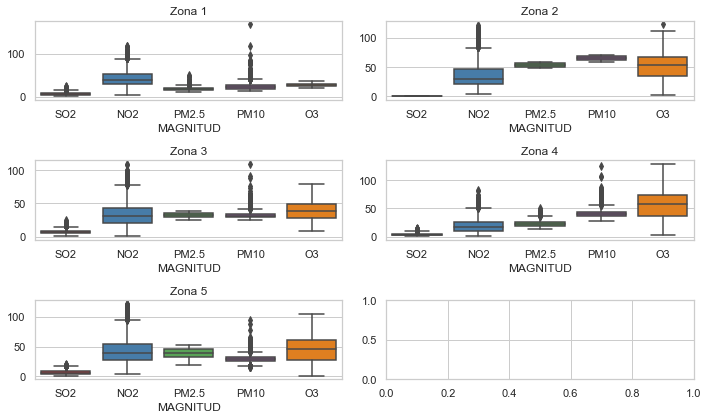

In [37]:
# Graficos outliers
sns.set(style="whitegrid")
fig, axs = plt.subplots(3, 2, figsize=(10, 6))

# Boxplot
sns.boxplot(data=zona1_media[contaminantes], ax=axs[0][0], palette="Set1")
sns.boxplot(data=zona2_media[contaminantes], ax=axs[0][1], palette="Set1")
sns.boxplot(data=zona3_media[contaminantes], ax=axs[1][0], palette="Set1")
sns.boxplot(data=zona4_media[contaminantes], ax=axs[1][1], palette="Set1")
sns.boxplot(data=zona5_media[contaminantes], ax=axs[2][0], palette="Set1")

# Titulos
axs[0][0].set_title("Zona 1")
axs[0][1].set_title("Zona 2")
axs[1][0].set_title("Zona 3")
axs[1][1].set_title("Zona 4")
axs[2][0].set_title("Zona 5")

fig.tight_layout()

plt.show()

## 1.5 Análisis de correlaciones

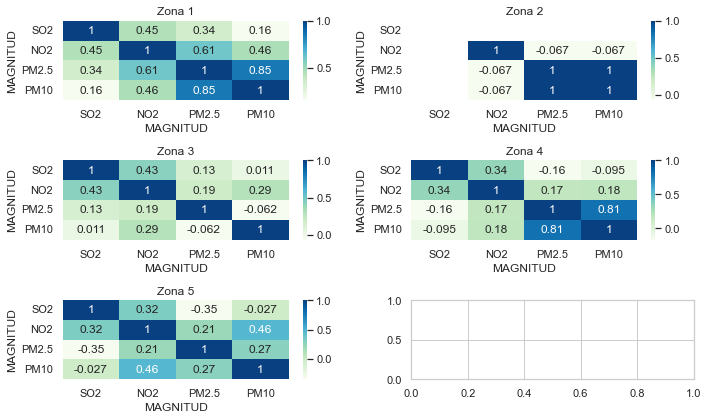

In [38]:
# Graficos correlaciones
fig, axs = plt.subplots(3, 2, figsize=(10, 6))

# Correlaciones
corr1 = zona1_media.loc[:,'SO2':'PM10'].corr()
sns.heatmap(data=corr1,ax=axs[0][0],cmap="GnBu",annot=True) 

corr2 = zona2_media.loc[:,'SO2':'PM10'].corr()
sns.heatmap(data=corr2,ax=axs[0][1],cmap="GnBu",annot=True) 

corr3 = zona3_media.loc[:,'SO2':'PM10'].corr()
sns.heatmap(data=corr3,ax=axs[1][0],cmap="GnBu",annot=True) 

corr4 = zona4_media.loc[:,'SO2':'PM10'].corr()
sns.heatmap(data=corr4,ax=axs[1][1],cmap="GnBu",annot=True) 

corr5 = zona5_media.loc[:,'SO2':'PM10'].corr()
sns.heatmap(data=corr5,ax=axs[2][0],cmap="GnBu",annot=True) 

# Titulos
axs[0][0].set_title("Zona 1")
axs[0][1].set_title("Zona 2")
axs[1][0].set_title("Zona 3")
axs[1][1].set_title("Zona 4")
axs[2][0].set_title("Zona 5")

fig.tight_layout()

plt.show()

# 2. Modelos de predicción

## 2.1 Análisis de Series Temporales: Modelos VAR y VARIMA.

Vamos a explorar el análisis de series temporales multivariantes con el propósito de realizar predicciones sobre la contaminación. En particular, nos enfocaremos en los modelos Vector Autoregressive (VAR) y Vector Autoregressive Moving Average (VARMA).

In [39]:
#!pip install statsmodels

In [40]:
# Librerias
import statsmodels.api as sm

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.vector_ar.vecm import coint_johansen

from sklearn import metrics
from sklearn.model_selection import ParameterGrid

from statsmodels.tsa.api import VAR
from statsmodels.tsa.statespace.varmax import VARMAX
from pmdarima import auto_arima

In [41]:
import warnings
warnings.filterwarnings("ignore")

Definimos algunas funciones que utilizaremos posteriormente

In [42]:
def mean_absolute_percentage_error_func(y_true, y_pred):
    '''
    Calculate the mean absolute percentage error as a metric for evaluation
    
    Args:
        y_true (float64): Y values for the dependent variable (test part), numpy array of floats 
        y_pred (float64): Predicted values for the dependen variable (test parrt), numpy array of floats
    
    Returns:
        Mean absolute percentage error 
    '''    
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [43]:
def timeseries_evaluation_metrics_func(y_true, y_pred):
    '''
    Calculate the following evaluation metrics:
        - MSE
        - MAE
        - RMSE
        - MAPE
        - R²
    
    Args:
        y_true (float64): Y values for the dependent variable (test part), numpy array of floats 
        y_pred (float64): Predicted values for the dependen variable (test parrt), numpy array of floats
    
    Returns:
        MSE, MAE, RMSE, MAPE and R² 
    '''    
    print('Evaluation metric results: ')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error_func(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')

In [44]:
def display_adfuller_results(result, name):
    print(f"Results for {name}:")
    print("ADF Statistic:", result[0])
    print("p-value:", result[1])
    print("Critical Values:")
    for key, value in result[4].items():
        print(f"   {key}: {value}")
    print("Conclusion:")
    if result[1] <= 0.05:
        print('\033[91m' + "Reject the null hypothesis")
        print('\033[91m' + "Data is stationary" + '\033[0m')
    else:
        print('\033[91m' + "Fail to reject the null hypothesis")
        print('\033[91m' + "Data is non-stationary" + '\033[0m')

In [45]:
def cointegration_test_func(df): 
    '''
    Test if there is a long-run relationship between features
    
    Args:
        dataframe (float64): Values of the columns to be checked, numpy array of floats 
    
    Returns:
        True or False whether a variable has a long-run relationship between other features
    ''' 
    johansen_cointegration_test = coint_johansen(df,-1,5)
    c = {'0.90':0, '0.95':1, '0.99':2}
    traces = johansen_cointegration_test.lr1
    cvts = johansen_cointegration_test.cvt[:, c[str(1-0.05)]]
    def adjust(val, length= 6): 
        return str(val).ljust(length)
    print('Column_Name  >  Test_Stat  >  C(95%)  =>  Signif  \n', '--'*25)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), '  >  ', 
              adjust(round(trace,2), 9), "  >  ", 
              adjust(cvt, 8), '  => ' , 
              trace > cvt)

In [46]:
def inverse_diff_func(actual_df, pred_df):
    '''
    Transforms the differentiated values back
    
    Args:
        actual dataframe (float64): Values of the columns, numpy array of floats 
        predicted dataframe (float64): Values of the columns, numpy array of floats 
    
    Returns:
        Dataframe with the predicted values
    '''
    df_temp = pred_df.copy()
    columns = actual_df.columns
    for col in columns: 
        df_temp[str(col)+'_inv_diff'] = actual_df[col].iloc[-1] + df_temp[str(col)].cumsum()
    return df_temp

### Zona 1

Comenzamos graficando las series temporales de los diferentes contaminantes en la zona 1.

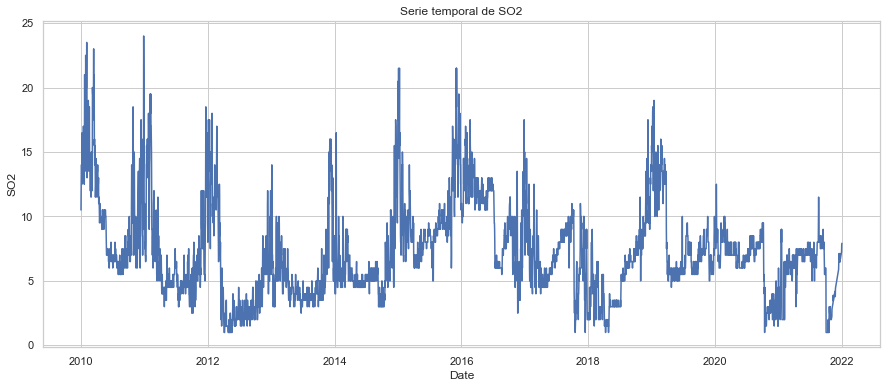

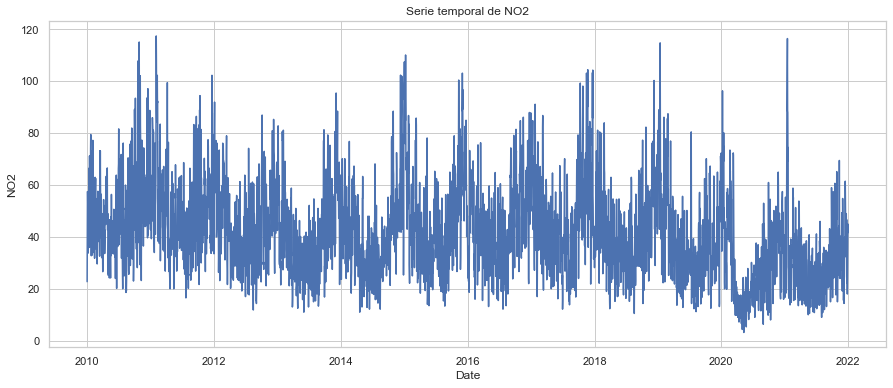

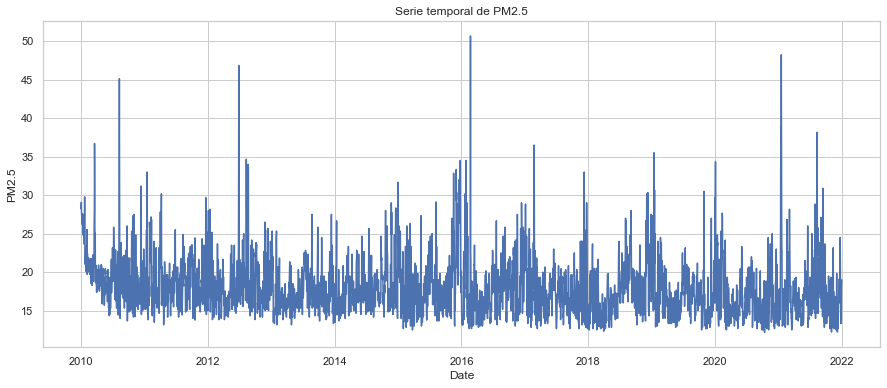

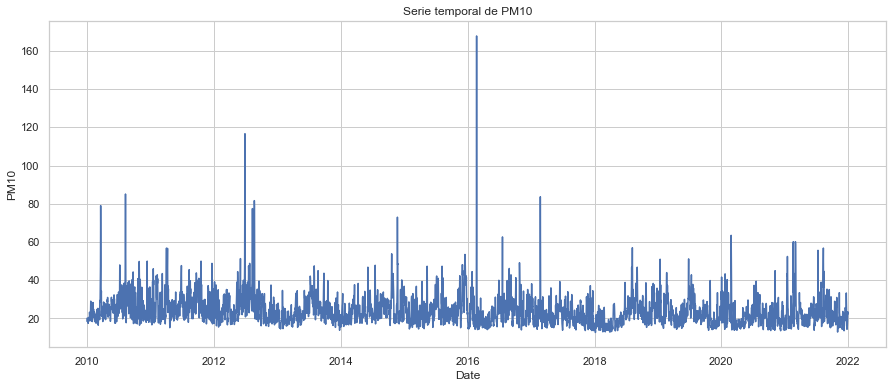

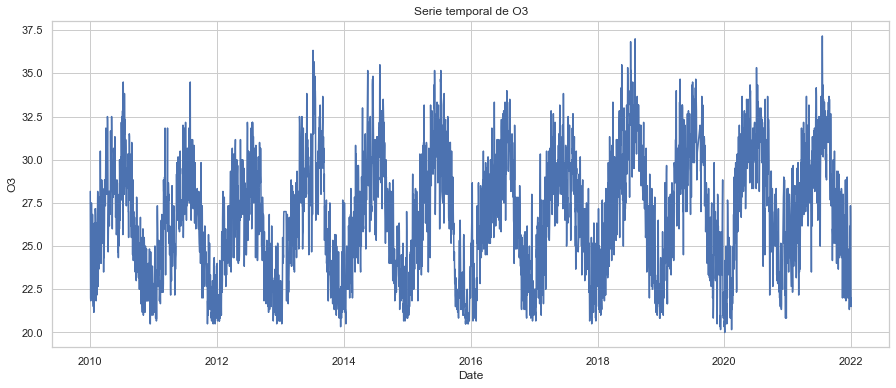

In [47]:
# Datos
ts_zona1 = zona1_media[['SO2','NO2','PM2.5','PM10', 'O3']]

# Grafico
for col in ts_zona1.columns:
    plt.figure(figsize=(15, 6))
    plt.plot(ts_zona1.index, ts_zona1[col])
    plt.xlabel("Date")
    plt.ylabel(col)
    plt.title(f"Serie temporal de {col}")
    plt.show()

En primer lugar, verificamos si la serie es estacionaria. Separamos los datos en dos conjuntos: datos de entrenamiento y datos de prueba (o test). Esta división nos permitirá utilizar el conjunto de entrenamiento para ajustar los modelos VAR y VARMA, mientras que el conjunto de prueba se utilizará posteriormente para evaluar el rendimiento y la precisión de los modelos.

In [48]:
# Datos de entrenamiento
train_zona1 = ts_zona1[(ts_zona1.index.year >= 2018) & (ts_zona1.index.year < 2021)]

# Datos de test
test_zona1 = zona1_media[(zona1_media.index.year >= 2021)]

In [49]:
# Test de Dickey-Fuller para train_zona1
for name, column in train_zona1[['SO2','NO2','PM2.5','PM10','O3']].iteritems():
    result = adfuller(column)
    display_adfuller_results(result, name)
    print('\n')

Results for SO2:
ADF Statistic: -2.7781195582286506
p-value: 0.06146784460649154
Critical Values:
   1%: -3.4363635475753824
   5%: -2.864195245967465
   10%: -2.5681837404258903
Conclusion:
Fail to reject the null hypothesis
Data is non-stationary


Results for NO2:
ADF Statistic: -3.4203153159113335
p-value: 0.010285514434580176
Critical Values:
   1%: -3.4364533503600962
   5%: -2.864234857527328
   10%: -2.568204837482531
Conclusion:
Reject the null hypothesis
Data is stationary


Results for PM2.5:
ADF Statistic: -3.963024417700346
p-value: 0.0016169947699779974
Critical Values:
   1%: -3.436459052172655
   5%: -2.864237372528562
   10%: -2.568206176974609
Conclusion:
Reject the null hypothesis
Data is stationary


Results for PM10:
ADF Statistic: -3.5473520751798033
p-value: 0.006851084414264955
Critical Values:
   1%: -3.436459052172655
   5%: -2.864237372528562
   10%: -2.568206176974609
Conclusion:
Reject the null hypothesis
Data is stationary


Results for O3:
ADF Statistic: 

Como no todas las variables de la serie cumplen con el criterio de estacionariedad, procedemos a realizar diferenciaciones simples y, posteriormente, aplicamos nuevamente algún test para comprobar si la serie resultante es estacionaria. Este proceso se repite hasta que se obtenga una serie estacionaria adecuada para el análisis.

In [50]:
train_diff = train_zona1.diff()
train_diff.dropna(inplace = True)

for name, column in train_diff.iteritems():
    result = adfuller(column)
    display_adfuller_results(result, name)
    print('\n')

Results for SO2:
ADF Statistic: -20.072317095112453
p-value: 0.0
Critical Values:
   1%: -3.4363635475753824
   5%: -2.864195245967465
   10%: -2.5681837404258903
Conclusion:
Reject the null hypothesis
Data is stationary


Results for NO2:
ADF Statistic: -10.234117434674149
p-value: 4.940425694359849e-18
Critical Values:
   1%: -3.4364533503600962
   5%: -2.864234857527328
   10%: -2.568204837482531
Conclusion:
Reject the null hypothesis
Data is stationary


Results for PM2.5:
ADF Statistic: -11.574800597137786
p-value: 3.0408810948389273e-21
Critical Values:
   1%: -3.436459052172655
   5%: -2.864237372528562
   10%: -2.568206176974609
Conclusion:
Reject the null hypothesis
Data is stationary


Results for PM10:
ADF Statistic: -11.38745211791569
p-value: 8.22323479994152e-21
Critical Values:
   1%: -3.436459052172655
   5%: -2.864237372528562
   10%: -2.568206176974609
Conclusion:
Reject the null hypothesis
Data is stationary


Results for O3:
ADF Statistic: -10.24199699463153
p-value

Una prueba de cointegración examina el movimiento conjunto entre las variables subyacentes a largo plazo. Esta característica de co-movimiento a largo plazo es lo que la distingue de la correlación. Dos o más variables están cointegradas si y solo si comparten tendencias comunes.

In [51]:
# Test cointegracion
cointegration_test_func(train_diff)

Column_Name  >  Test_Stat  >  C(95%)  =>  Signif  
 --------------------------------------------------
SO2      >   1717.2      >   60.0627    =>  True
NO2      >   1177.49     >   40.1749    =>  True
PM2.5    >   809.44      >   24.2761    =>  True
PM10     >   503.2       >   12.3212    =>  True
O3       >   222.82      >   4.1296     =>  True


### Vector Autoregressive (VAR)

El modelo Vector AutoRegressive (VAR) es un modelo de procesos estocásticos ampliamente utilizado en el análisis de series temporales multivariantes. Su objetivo principal es capturar la relación lineal entre múltiples variables observadas en diferentes momentos del tiempo. En esencia, el VAR es un modelo bidireccional, lo que significa que las variables se influyen mutuamente a lo largo del tiempo.

En primer lugar, seleccionamos el mejor parámetro para la componente AR basándonos en algún criterio, como el Criterio de Información de Akaike (AIC) o el Criterio de Información Bayesiana (BIC).

In [52]:
# Busqueda de hiperparamentro del modelo
df_results_VAR = pd.DataFrame()

for i in [1,2,3,4,5,6,7,8,9]:
    fit_v = VAR(train_diff).fit(i)
    aic = fit_v.aic
    bic = fit_v.bic
    df1 = {'AR_Term':i, 'AIC': aic, 'BIC': bic}
    df_results_VAR = df_results_VAR.append(df1, ignore_index=True)
    clist = ['AR_Term','AIC','BIC']
    df_results_VAR = df_results_VAR[clist]  
    
# Parametro del modelo VAR
best_values_VAR = df_results_VAR.sort_values(by=['AIC', 'BIC'])
print(best_values_VAR.head(1))

AR_Term_value_VAR = best_values_VAR['AR_Term'].iloc[0]

   AR_Term       AIC       BIC
6      7.0  7.820245  8.646143


Ajustamos el modelo con el parámetro que obtiene mejores resultados y realizamos predicciones.

In [53]:
# Ajuste del modelo
model = VAR(train_diff).fit(int(AR_Term_value_VAR))

# Predicciones
result = model.forecast(y=train_diff.values, steps=len(test_zona1))

In [54]:
# Predicciones
df_pred = pd.DataFrame(result, columns=train_diff.columns)
df_pred["new_index"] = range(len(train_zona1), len(ts_zona1[(ts_zona1.index.year >= 2018)]))
df_pred = df_pred.set_index("new_index")

# Deshacer transformacion de diferenciacion
res = inverse_diff_func(train_zona1, df_pred)
res.head()

MAGNITUD,SO2,NO2,PM2.5,PM10,O3,SO2_inv_diff,NO2_inv_diff,PM2.5_inv_diff,PM10_inv_diff,O3_inv_diff
new_index,,,,,,,,,,
1096,-0.691601,1.581776,0.661736,1.495253,-1.559741,5.308399,33.181776,15.772847,18.828587,26.051370
1097,-0.510061,3.822183,-0.345249,-0.114906,-0.820253,4.798338,37.003958,15.427598,18.713681,25.231117
1098,-0.267671,-2.609033,-0.699623,-0.451975,1.037081,4.530667,34.394925,14.727975,18.261705,26.268199
1099,-0.014534,3.154653,1.168460,1.431823,-0.447582,4.516132,37.549578,15.896435,19.693528,25.820616
1100,0.090418,-0.054955,0.104553,0.450438,0.308915,4.606550,37.494623,16.000988,20.143966,26.129531


Evaluamos el modelo VAR según las diferentes métricas

In [55]:
# Metricas para evaluar el ajuste del modelo
for i in ['SO2','NO2','PM2.5','PM10','O3']:
    print(f'Evaluation metric for {i}')
    timeseries_evaluation_metrics_func(test_zona1[str(i)] , res[str(i)+'_inv_diff'])

Evaluation metric for SO2
Evaluation metric results: 
MSE is : 5.296312805371494
MAE is : 2.086258444955092
RMSE is : 2.3013719398157906
MAPE is : 52.947414607920166
R2 is : -0.25083429279658387

Evaluation metric for NO2
Evaluation metric results: 
MSE is : 227.7497100173352
MAE is : 11.328888707306406
RMSE is : 15.091378665229204
MAPE is : 45.951432835062356
R2 is : -0.023555511291749598

Evaluation metric for PM2.5
Evaluation metric results: 
MSE is : 23.46437254573133
MAE is : 2.9683577998375847
RMSE is : 4.844003772266422
MAPE is : 14.759108184868328
R2 is : -0.1406879959695444

Evaluation metric for PM10
Evaluation metric results: 
MSE is : 74.78921797693883
MAE is : 5.517090668274352
RMSE is : 8.648075969655842
MAPE is : 20.398745716404008
R2 is : -0.21211607566355695

Evaluation metric for O3
Evaluation metric results: 
MSE is : 12.427035180289197
MAE is : 2.9233254386813536
RMSE is : 3.525200019898048
MAPE is : 10.1846445227764
R2 is : -0.2513285550110216



Graficamos la serie real y las predicciones realizadas por el modelo VAR.

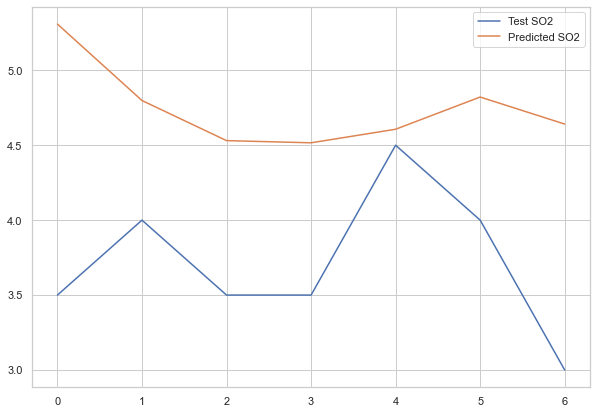

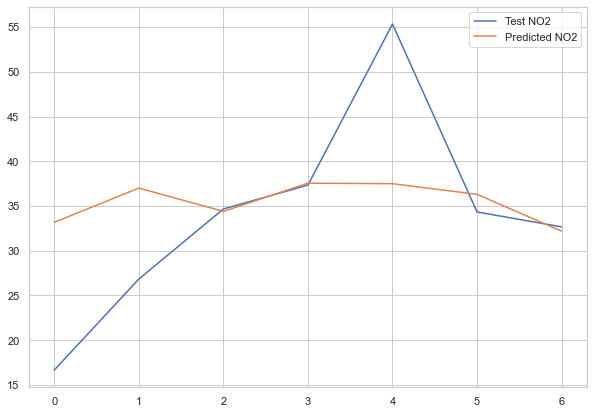

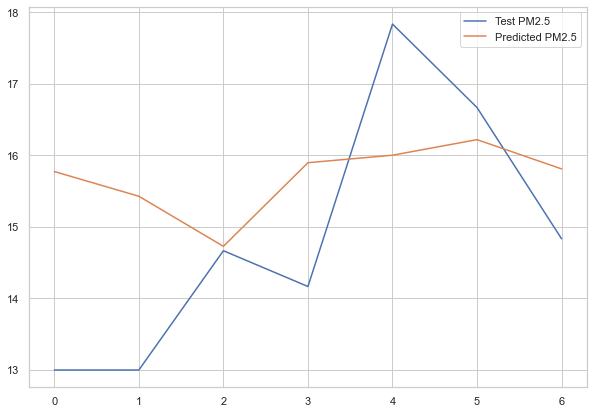

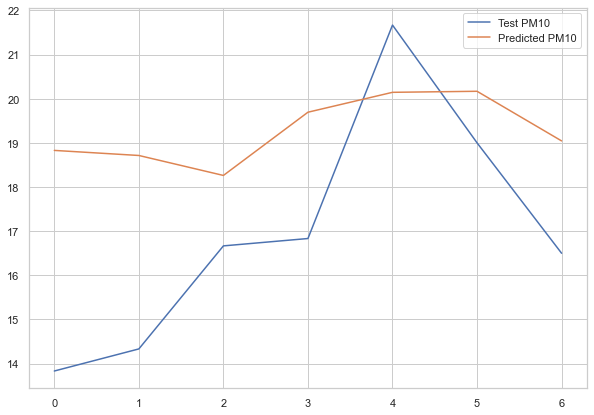

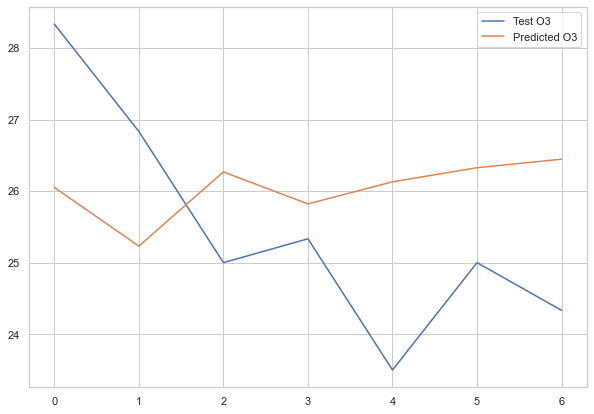

In [56]:
for i in ['SO2','NO2','PM2.5','PM10','O3']:    
    plt.rcParams["figure.figsize"] = [10,7]
    #plt.plot(train_zona1[str(i)], label='Train '+str(i))
    plt.plot(test_zona1[str(i)].values[0:7], label='Test '+str(i))
    plt.plot(res[str(i)+'_inv_diff'].values[0:7], label='Predicted '+str(i))
    plt.legend(loc='best')
    plt.show()

Por último, aplicamos los índices a los valores que se han predecido y comparamos con el índice real.

In [57]:
# Indice para SO2
res['I1'] = indice_parcial(res['SO2_inv_diff'], 'SO2')

# Indice para N02
res['I2'] = indice_parcial(res['NO2_inv_diff'], 'NO2')

# Indice para PM2.5
res['I3'] = indice_parcial(res['PM2.5_inv_diff'], 'PM2.5')

# Indice para PM10
res['I4'] = indice_parcial(res['PM10_inv_diff'], 'PM10')

# Indice para O3
res['I5'] = indice_parcial(res['O3_inv_diff'], 'O3')

# Indice general
res['ICA'] = res.loc[:,'I1':'I5'].apply(indice_general,axis=1)

In [58]:
# Metricas para evaluar el ajuste del modelo
for i in ['I1','I2','I3','I4','I5']:
    print(f'Evaluation metric for {i}')
    timeseries_evaluation_metrics_func(test_zona1[i] , res[i])

Evaluation metric for I1
Evaluation metric results: 
MSE is : 0.0
MAE is : 0.0
RMSE is : 0.0
MAPE is : 0.0
R2 is : 1.0

Evaluation metric for I2
Evaluation metric results: 
MSE is : 0.10684931506849316
MAE is : 0.09041095890410959
RMSE is : 0.32687813488897227
MAPE is : 4.2465753424657535
R2 is : -0.08283888635326342

Evaluation metric for I3
Evaluation metric results: 
MSE is : 0.3589041095890411
MAE is : 0.3589041095890411
RMSE is : 0.5990860619218586
MAPE is : 34.24657534246575
R2 is : -0.3589984083674398

Evaluation metric for I4
Evaluation metric results: 
MSE is : 0.336986301369863
MAE is : 0.29863013698630136
RMSE is : 0.5805052121814782
MAPE is : 14.292237442922373
R2 is : -0.3598776276731086

Evaluation metric for I5
Evaluation metric results: 
MSE is : 0.0
MAE is : 0.0
RMSE is : 0.0
MAPE is : 0.0
R2 is : 1.0



### Vector Autorregressive Moving Avarage (VARMA)

El modelo VARIMA (Vector Autoregressive Integrated Moving Average) es una extensión del modelo ARIMA (Autoregressive Integrated Moving Average) que se utiliza para analizar y predecir series de tiempo multivariadas. A diferencia del modelo ARIMA, que se enfoca en una sola serie de tiempo, el modelo VARIMA permite modelar y capturar las interacciones y dependencias entre múltiples series de tiempo simultáneamente.

En primer lugar, buscamos los hiperparámetros del modelo ($p$ y $q$
) basándonos en algún criterio, como el Criterio de Información de Akaike (AIC) o el Criterio de Información Bayesiana (BIC).

In [59]:
# Define a range of values for p and q
p_values = range(1, 4)  # Autoregressive order
q_values = range(1, 4)  # Moving average order

# Fixed differencing order
d = 1

# Initialize variables to store best model and minimum AIC
best_model = None
best_aic = float("inf")

# Perform grid search
for p, q in product(p_values, q_values):
    # Create the VARIMA model
    model = VARMAX(train_diff, order=(p, 0, q))
    
    # Fit the model
    results = model.fit(maxiter=1000)
    
    # Calculate AIC
    aic = results.aic
    
    # Check if this model has the lowest AIC so far
    if aic < best_aic:
        best_aic = aic
        best_model = results
        best_p = p
        best_q = q

# Print the best model's summary
print("Best Model (p, q):", (best_p, best_q))
print(best_model.summary())

Best Model (p, q): (3, 1)
                                     Statespace Model Results                                    
Dep. Variable:     ['SO2', 'NO2', 'PM2.5', 'PM10', 'O3']   No. Observations:                 1095
Model:                                            VAR(3)   Log Likelihood              -12066.414
                                             + intercept   AIC                          24322.828
Date:                                   Mon, 28 Aug 2023   BIC                          24797.687
Time:                                           19:03:07   HQIC                         24502.511
Sample:                                       01-02-2018                                         
                                            - 12-31-2020                                         
Covariance Type:                                     opg                                         
Ljung-Box (L1) (Q):     0.14, 0.81, 0.20, 0.54, 0.32   Jarque-Bera (JB):   1365.22, 45.85, 9

Asi, ajustamos el modelo y realizamos predicciones

In [60]:
# Ajuste del modelo
model = VARMAX(train_diff, order=(best_p, 0, best_q))
results = model.fit(maxiter=1000)

# Predicciones
pred = results.forecast(y=train_diff.values, steps=len(test_zona1))

In [61]:
# Predicciones
df_pred_VARIMA = pd.DataFrame(pred, columns=train_diff.columns)
df_pred_VARIMA["new_index"] = range(len(train_zona1), len(ts_zona1[(ts_zona1.index.year >= 2018)]))
df_pred_VARIMA = df_pred_VARIMA.set_index("new_index")

# Deshacer transformacion de diferenciacion
res_VARIMA = inverse_diff_func(train_zona1, df_pred_VARIMA)
res_VARIMA.head()

MAGNITUD,SO2,NO2,PM2.5,PM10,O3,SO2_inv_diff,NO2_inv_diff,PM2.5_inv_diff,PM10_inv_diff,O3_inv_diff
new_index,,,,,,,,,,
1096,-0.678738,-0.631192,-0.027884,0.777113,-0.498936,5.321262,30.968808,15.083228,18.110446,27.112175
1097,-0.506478,2.715571,-0.010444,0.420393,-0.686224,4.814784,33.684379,15.072783,18.530839,26.425951
1098,-0.366101,-3.137102,-1.012754,-1.593739,0.527882,4.448682,30.547277,14.060030,16.937100,26.953833
1099,0.221023,-0.193083,0.264981,-0.033767,0.279809,4.669706,30.354194,14.325011,16.903333,27.233642
1100,0.110588,0.372431,0.247994,0.461741,-0.067031,4.780294,30.726625,14.573005,17.365075,27.166612


Evaluamos el modelo VARMA según las diferentes métricas

In [62]:
# Metricas para evaluar el ajuste del modelo
for i in ['SO2','NO2','PM2.5','PM10','O3']:
    print(f'Evaluation metric for {i}')
    timeseries_evaluation_metrics_func(test_zona1[str(i)] , res_VARIMA[str(i)+'_inv_diff'])

Evaluation metric for SO2
Evaluation metric results: 
MSE is : 4.808954323313514
MAE is : 1.94346061380397
RMSE is : 2.192932813223769
MAPE is : 54.13993644147486
R2 is : -0.13573446303857706

Evaluation metric for NO2
Evaluation metric results: 
MSE is : 222.66078538471308
MAE is : 10.756272999273923
RMSE is : 14.921822455206772
MAPE is : 41.30923231849096
R2 is : -0.0006848044360867611

Evaluation metric for PM2.5
Evaluation metric results: 
MSE is : 28.290167171150603
MAE is : 3.3161335713310103
RMSE is : 5.318850173782921
MAPE is : 15.983083498625989
R2 is : -0.3752873226509448

Evaluation metric for PM10
Evaluation metric results: 
MSE is : 92.28488276446667
MAE is : 6.279730726542417
RMSE is : 9.606502108700475
MAPE is : 22.351669534954063
R2 is : -0.4956700038504034

Evaluation metric for O3
Evaluation metric results: 
MSE is : 10.621119525570679
MAE is : 2.6878446511218677
RMSE is : 3.2590059106375793
MAPE is : 9.60081614328217
R2 is : -0.06948358604569549



Graficamos las predicciones frente a los valores reales

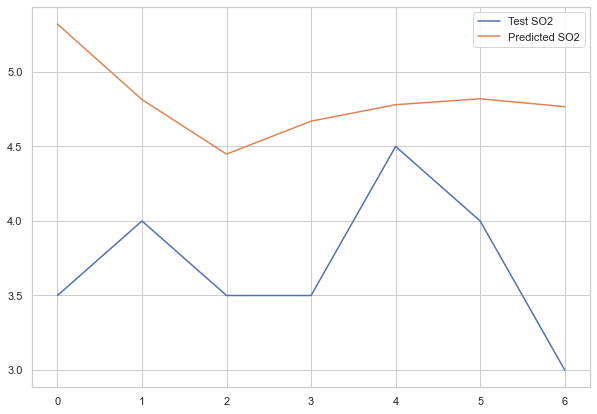

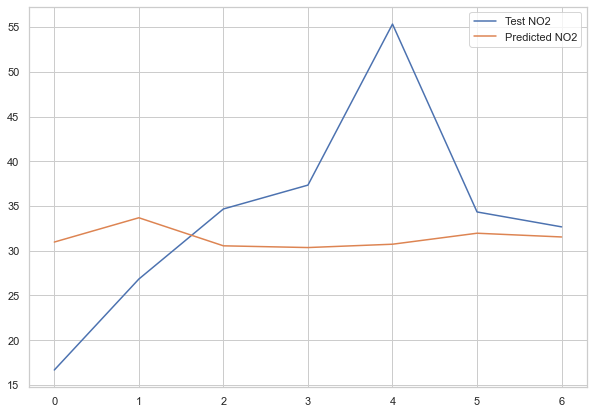

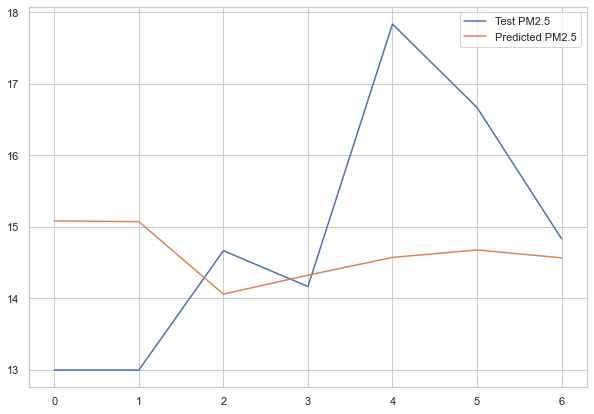

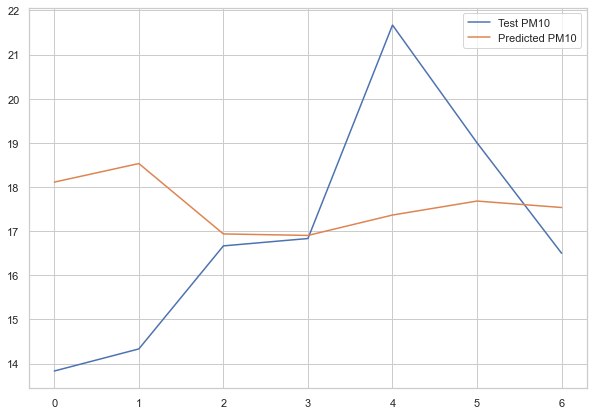

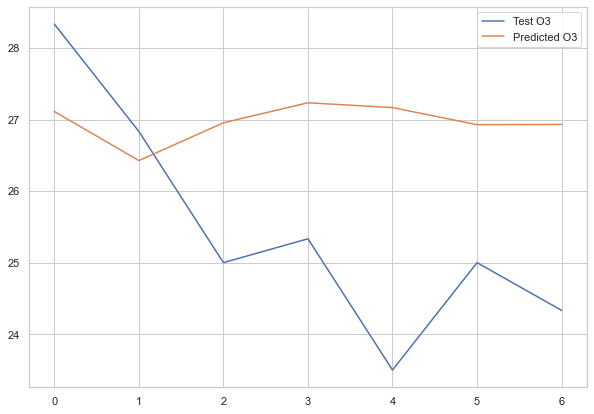

In [63]:
for i in ['SO2','NO2','PM2.5','PM10','O3']:    
    plt.rcParams["figure.figsize"] = [10,7]
    #plt.plot(train_zona1[str(i)], label='Train '+str(i))
    plt.plot(test_zona1[str(i)].values[0:7], label='Test '+str(i))
    plt.plot(res_VARIMA[str(i)+'_inv_diff'].values[0:7], label='Predicted '+str(i))
    plt.legend(loc='best')
    plt.show()

Por último, generamos los índices parciales para las predicciones de los contaminantes y comparamos con el índice real.

In [64]:
# Indice para SO2
res_VARIMA['I1'] = indice_parcial(res_VARIMA['SO2_inv_diff'], 'SO2')

# Indice para N02
res_VARIMA['I2'] = indice_parcial(res_VARIMA['NO2_inv_diff'], 'NO2')

# Indice para PM2.5
res_VARIMA['I3'] = indice_parcial(res_VARIMA['PM2.5_inv_diff'], 'PM2.5')

# Indice para PM10
res_VARIMA['I4'] = indice_parcial(res_VARIMA['PM10_inv_diff'], 'PM10')

# Indice para O3
res_VARIMA['I5'] = indice_parcial(res_VARIMA['O3_inv_diff'], 'O3')

# Indice general
res_VARIMA['ICA'] = res_VARIMA.loc[:,'I1':'I5'].apply(indice_general,axis=1)

In [65]:
# Metricas para evaluar el ajuste del modelo
for i in ['I1','I2','I3','I4','I5']:
    print(f'Evaluation metric for {i}')
    timeseries_evaluation_metrics_func(test_zona1[i] , res_VARIMA[i])

Evaluation metric for I1
Evaluation metric results: 
MSE is : 0.0
MAE is : 0.0
RMSE is : 0.0
MAPE is : 0.0
R2 is : 1.0

Evaluation metric for I2
Evaluation metric results: 
MSE is : 0.10684931506849316
MAE is : 0.09041095890410959
RMSE is : 0.32687813488897227
MAPE is : 4.2465753424657535
R2 is : -0.08283888635326342

Evaluation metric for I3
Evaluation metric results: 
MSE is : 0.7424657534246575
MAE is : 0.6931506849315069
RMSE is : 0.8616645248730259
MAPE is : 34.10958904109589
R2 is : -1.811363119599818

Evaluation metric for I4
Evaluation metric results: 
MSE is : 0.336986301369863
MAE is : 0.29863013698630136
RMSE is : 0.5805052121814782
MAPE is : 14.292237442922373
R2 is : -0.3598776276731086

Evaluation metric for I5
Evaluation metric results: 
MSE is : 0.0
MAE is : 0.0
RMSE is : 0.0
MAPE is : 0.0
R2 is : 1.0



**Conclusión**

## 2.2 Modelo de Red Neuronal Recurrente (RNN)

In [66]:
#!pip install --upgrade numpy tensorflow

In [67]:
# Librerias
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [76]:
# Crear una instancia de MinMaxScaler
scaler = MinMaxScaler()

# Escalar los datos de entrenamiento
train_scaled = scaler.fit_transform(train_zona1)

# Definir la ventana de tiempo para el modelo LSTM
time_steps = 10  # Puedes ajustar este valor según tus necesidades

# Crear los conjuntos de entrada y salida para el modelo LSTM
X_train = []
y_train = []
for i in range(len(train_scaled) - time_steps):
    X_train.append(train_scaled[i:i+time_steps])
    y_train.append(train_scaled[i+time_steps])

X_train = np.array(X_train)
y_train = np.array(y_train)

# Definir el modelo LSTM
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(time_steps, train_scaled.shape[1])))
model.add(Dense(train_scaled.shape[1]))  # Capa de salida con el mismo número de características

# Compilar el modelo
model.compile(optimizer='adam', loss='mse')

# Entrenar el modelo
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1)

# Hacer predicciones
forecast_steps = 7  # Número de pasos a predecir en el futuro
forecast = []

# Utilizar la última ventana de tiempo en los datos de entrenamiento para hacer predicciones
last_window = train_scaled[-time_steps:]

for _ in range(forecast_steps):
    # Preparar la ventana de tiempo actual para la predicción
    current_window = last_window[-time_steps:]
    current_window = current_window.reshape(1, time_steps, train_scaled.shape[1])
    
    # Hacer la predicción para la ventana de tiempo actual
    prediction = model.predict(current_window)
    
    # Agregar la predicción a la lista de pronósticos
    forecast.append(prediction)
    
    # Actualizar la ventana de tiempo para la siguiente iteración
    last_window = np.concatenate((last_window, prediction), axis=0)

# Convertir la lista de pronósticos en una matriz (7x5)
forecast = np.array(forecast).reshape(forecast_steps, train_scaled.shape[1])
forecast = scaler.inverse_transform(forecast)  # Desescalar las predicciones

# Imprimir las predicciones
print("Predicciones:")
print(forecast)

Epoch 1/50
34/34 [==============================] - 2s 5ms/step - loss: 0.0564
Epoch 2/50
34/34 [==============================] - 0s 5ms/step - loss: 0.0195
Epoch 3/50
34/34 [==============================] - 0s 5ms/step - loss: 0.0138
Epoch 4/50
34/34 [==============================] - 0s 5ms/step - loss: 0.0121
Epoch 5/50
34/34 [==============================] - 0s 5ms/step - loss: 0.0116
Epoch 6/50
34/34 [==============================] - 0s 5ms/step - loss: 0.0113
Epoch 7/50
34/34 [==============================] - 0s 5ms/step - loss: 0.0110
Epoch 8/50
34/34 [==============================] - 0s 5ms/step - loss: 0.0108
Epoch 9/50
34/34 [==============================] - 0s 5ms/step - loss: 0.0107
Epoch 10/50
34/34 [==============================] - 0s 5ms/step - loss: 0.0106
Epoch 11/50
34/34 [==============================] - 0s 5ms/step - loss: 0.0104
Epoch 12/50
34/34 [==============================] - 0s 6ms/step - loss: 0.0104
Epoch 13/50
34/34 [==============================

In [78]:
test_zona1['']

MAGNITUD,SO2,NO2,PM2.5,PM10,O3,I1,I2,I3,I4,I5,ICA
date,,,,,,,,,,,
2021-01-01,3.500000,16.666667,13.000000,13.833333,28.333333,1,1,1,1,1,1
2021-01-02,4.000000,26.833333,13.000000,14.333333,26.833333,1,1,1,1,1,1
2021-01-03,3.500000,34.666667,14.666667,16.666667,25.000000,1,1,1,1,1,1
2021-01-04,3.500000,37.333333,14.166667,16.833333,25.333333,1,1,1,1,1,1
2021-01-05,4.500000,55.333333,17.833333,21.666667,23.500000,1,2,2,1,1,2
...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,7.096774,18.000000,13.333333,16.333333,27.333333,1,1,1,1,1,1
2021-12-28,7.177419,24.166667,13.833333,18.500000,26.500000,1,1,1,1,1,1
2021-12-29,7.258065,38.833333,18.166667,23.166667,23.000000,1,1,2,1,1,2


In [77]:
forecast

array([[ 4.017649 , 37.605656 , 15.705594 , 18.915565 , 26.387474 ],
       [ 4.145895 , 39.05639  , 16.067633 , 19.596855 , 26.302324 ],
       [ 4.297225 , 39.753357 , 16.290625 , 19.956417 , 26.349285 ],
       [ 4.354075 , 40.049606 , 16.397575 , 20.116316 , 26.399727 ],
       [ 4.446578 , 40.076595 , 16.460085 , 20.308325 , 26.398975 ],
       [ 4.5098796, 39.9935   , 16.492836 , 20.395597 , 26.392216 ],
       [ 4.574863 , 40.110416 , 16.463549 , 20.443344 , 26.410807 ]],
      dtype=float32)

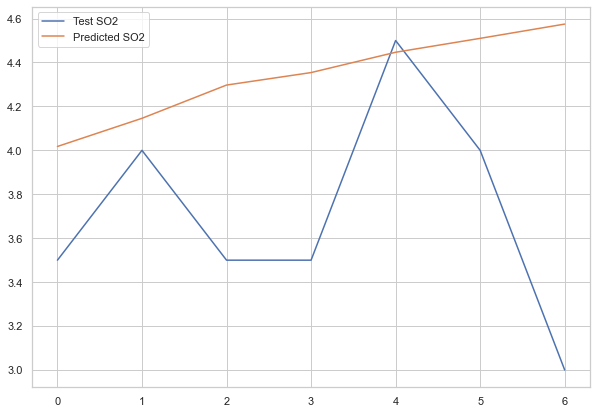

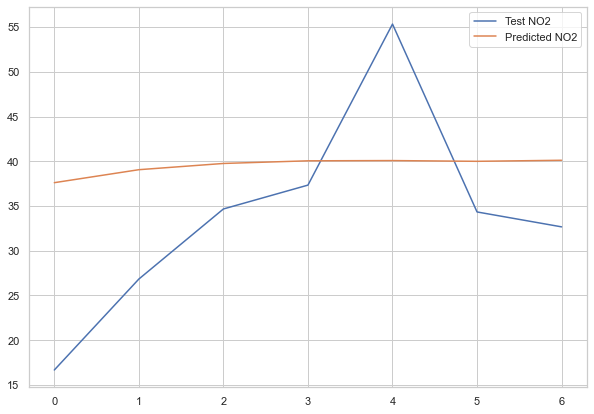

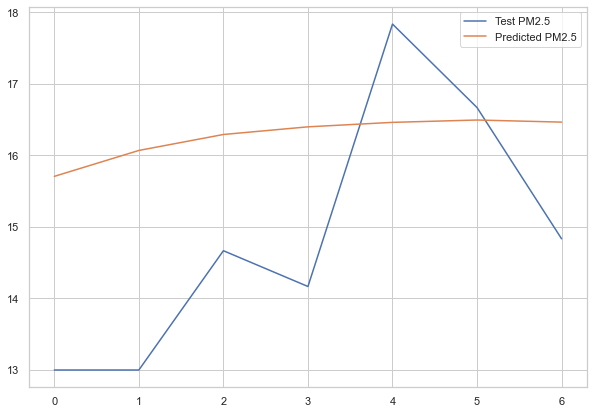

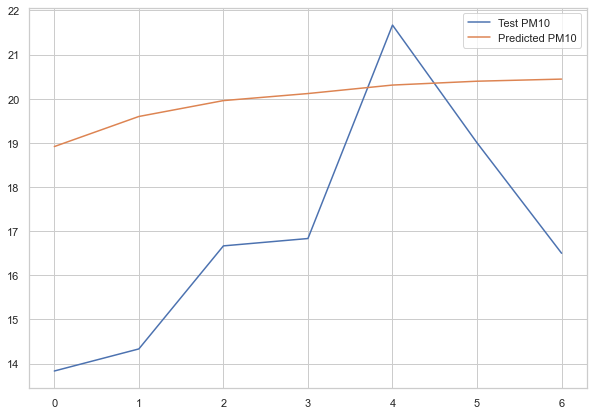

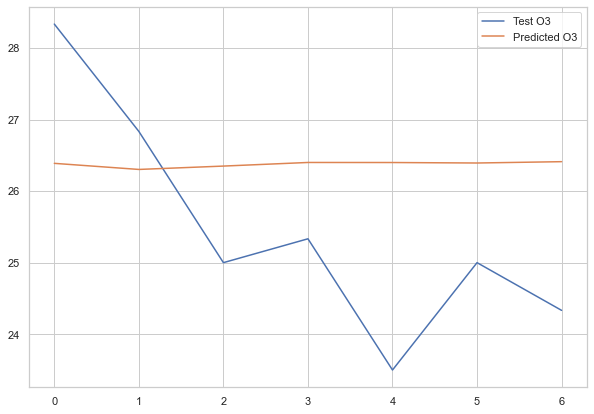

In [81]:
variable_indices = {'SO2': 0, 'NO2': 1, 'PM2.5': 2, 'PM10': 3, 'O3': 4}

for i in ['SO2', 'NO2', 'PM2.5', 'PM10', 'O3']:
    plt.rcParams["figure.figsize"] = [10, 7]
    #plt.plot(train_zona1[str(i)], label='Train '+str(i))
    plt.plot(test_zona1[str(i)].values[0:7], label='Test '+str(i))
    plt.plot(forecast[:, variable_indices[i]], label='Predicted '+str(i))
    plt.legend(loc='best')
    plt.show()